In [149]:
import re
import nltk
import gensim
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [2]:
sns.set_context('talk')

In [28]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()    

def remove_tags(text):    
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

def remove_stop_words(tokenized_text):
    return [w for w in tokenized_text if not w in set(stopwords.words('english'))]

def normalize_text(text: str) -> str:
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)
    
    return text

In [22]:
class_corpus = pd.read_csv('ClassCorpus_V2.csv')

In [23]:
class_corpus.head()

,FileName,StudentName,Genre,ReviewType,MovieTitle,MovieReview
0,KHS_Doc1_TheRing,KHS,Horror,Negative,The Ring,"Described as a drama, horror and mystery, The ..."
1,KHS_Doc2_TheRing,KHS,Horror,Negative,The Ring,"I hated it, but I grant that it does tap into..."
2,KHS_Doc3_TheRing,KHS,Horror,Negative,The Ring,Ehren Kruger (no relation to Freddy) showed a ...
3,KHS_Doc4_TheRing,KHS,Horror,Negative,The Ring,Not all arthouse thrillers are destined to be ...
4,KHS_Doc5_TheRing,KHS,Horror,Negative,The Ring,Rarely has a more serious effort produced a le...


In [24]:
class_corpus_copy = class_corpus.copy()

In [25]:
class_corpus_copy['normalized_review_text'] = class_corpus_copy['MovieReview'].apply(normalize_text)

In [27]:
class_corpus_copy.loc[:, ['MovieReview', 'normalized_review_text']].head()

,MovieReview,normalized_review_text
0,"Described as a drama, horror and mystery, The ...",described as a drama horror and mystery the ri...
1,"I hated it, but I grant that it does tap into...",i hated it but i grant that it does tap into ...
2,Ehren Kruger (no relation to Freddy) showed a ...,ehren kruger no relation to freddy showed a ge...
3,Not all arthouse thrillers are destined to be ...,not all arthouse thrillers are destined to be ...
4,Rarely has a more serious effort produced a le...,rarely has a more serious effort produced a le...


# Vectorizing documents

## Method 1: TF-IDF

Representing the documents as vectors in the vocabulary space using TF-IDF scores

In [29]:
vectorizer_tfidf = TfidfVectorizer(stop_words=set(stopwords.words('english')))

In [30]:
tfidf_corpus = vectorizer_tfidf.fit_transform(class_corpus_copy['normalized_review_text'])

In [36]:
tfidf_vectors_corpus = pd.DataFrame(tfidf_corpus.toarray(), 
                                    columns=vectorizer_tfidf.get_feature_names_out(), 
                                    index=class_corpus_copy.index)

In [37]:
tfidf_vectors_corpus.shape

(190, 14974)

In [39]:
tfidf_vectors_corpus.loc[0, :]

abandoned     0.0
abandoning    0.0
abanoub       0.0
abashed       0.0
abating       0.0
             ... 
zooming       0.0
zoomy         0.0
zora          0.0
zorro         0.0
zuckerberg    0.0
Name: 0, Length: 14974, dtype: float64

## Method 2: `Doc2Vec`

Representing each document in the embedding space using [`Doc2Vec`](https://arxiv.org/pdf/1405.4053v2.pdf)

In [42]:
class_corpus_copy['normalized_review_tokens'] = class_corpus_copy['normalized_review_text'].apply(nltk.word_tokenize)
class_corpus_copy['normalized_review_tokens'] = class_corpus_copy['normalized_review_tokens'].apply(remove_stop_words)

In [44]:
(class_corpus_copy.loc[:, ['MovieReview', 'normalized_review_text', 'normalized_review_tokens']]
                  .head())

,MovieReview,normalized_review_text,normalized_review_tokens
0,"Described as a drama, horror and mystery, The ...",described as a drama horror and mystery the ri...,"[described, drama, horror, mystery, ring, horr..."
1,"I hated it, but I grant that it does tap into...",i hated it but i grant that it does tap into ...,"[hated, grant, tap, vein, technological, horro..."
2,Ehren Kruger (no relation to Freddy) showed a ...,ehren kruger no relation to freddy showed a ge...,"[ehren, kruger, relation, freddy, showed, genu..."
3,Not all arthouse thrillers are destined to be ...,not all arthouse thrillers are destined to be ...,"[arthouse, thrillers, destined, ruined, hollyw..."
4,Rarely has a more serious effort produced a le...,rarely has a more serious effort produced a le...,"[rarely, serious, effort, produced, less, seri..."


In [74]:
review_tokens_corpus = class_corpus_copy['normalized_review_tokens']

In [49]:
tagged_documents = [TaggedDocument(review_tokens, [i]) 
                    for i, review_tokens in enumerate(review_tokens_corpus)]

In [50]:
tagged_documents[0]

TaggedDocument(words=['described', 'drama', 'horror', 'mystery', 'ring', 'horrifically', 'filmed', 'allegedly', 'dramatic', 'work', 'mystery', 'movie', 'ever', 'made', 'based', 'japanese', 'novel', 'ringu', 'remake', 'hideo', 'nakata', 'japanese', 'film', 'name', 'written', 'hiroshi', 'takahashi', 'ring', 'story', 'mysterious', 'videotape', 'kills', 'viewers', 'seven', 'days', 'seeing', 'tape', 'watch', 'tape', 'phone', 'rings', 'ominous', 'voice', 'tells', 'die', 'wait', 'week', 'die', 'piece', 'cake', 'seems', 'luck', 'would', 'young', 'teenaged', 'girl', 'named', 'katie', 'journalist', 'aunt', 'dies', 'seeing', 'tape', 'sending', 'aunt', 'investigative', 'mode', 'cause', 'katies', 'death', 'initially', 'aunt', 'rachel', 'views', 'alleged', 'myth', 'tape', 'great', 'cynicism', 'skepticism', 'suffering', 'nightmares', 'bizarre', 'physical', 'symptoms', 'mention', 'realizing', 'young', 'son', 'viewed', 'tape', 'begins', 'believe', 'something', 'evil', 'going', 'may', 'truth', 'legacy',

Two key hyperparameters to keep in mind while we work with Doc2Vec is the `embedding` dimension and the `window` size.

To avoid infrequent words (the long tail), we might want to restrict the `min_count` parameter.

In [206]:
model_doc2vec = Doc2Vec(tagged_documents,
                        vector_size=100,
                        window=3,
                        min_count=2)

In [207]:
model_doc2vec.infer_vector(review_tokens_corpus[0])

array([-0.8737392 , -0.9754083 , -0.04677773, -0.00873916, -0.24345328,
       -0.25828594,  0.10859907,  0.43284616,  0.16339013,  0.3387927 ,
        0.37267712,  0.4502329 , -0.06496087, -0.59493905,  0.23213503,
        0.3021128 , -0.35284752,  0.50435126, -0.16321227,  0.17409332,
        0.4509245 , -0.31002715,  1.0427468 , -1.8291677 ,  0.12559049,
        0.90181714,  0.8942417 , -0.43158785, -0.3074751 ,  1.0254965 ,
       -0.8271346 , -0.7545851 , -0.2707015 , -1.824565  , -0.5061409 ,
       -0.4091496 ,  0.46979573, -2.323473  , -0.44126284, -0.5484306 ,
       -0.3083939 ,  0.6563588 ,  0.07035815, -0.0180777 , -0.4134582 ,
        0.6022267 ,  0.5861687 , -0.3606131 ,  0.597439  ,  0.21577424,
       -1.3062915 , -1.2743512 ,  0.20396022, -0.03730412, -1.334417  ,
        0.19532284,  0.3844644 , -0.7807368 , -0.51481086, -0.07087898,
        0.33060288,  0.13815461, -0.82439786, -0.48677963,  0.15166548,
        0.74125564, -0.81162703, -0.23389836, -0.27040845,  0.83

In [208]:
doc2vec_corpus = pd.DataFrame()

for review_tokens in review_tokens_corpus:
    doc_vector = pd.DataFrame(model_doc2vec.infer_vector(review_tokens)).transpose()
    doc2vec_corpus = pd.concat([doc2vec_corpus, doc_vector], axis=0)

doc2vec_corpus.index = class_corpus_copy.index

In [209]:
doc2vec_corpus.shape

(190, 100)

In [210]:
doc2vec_corpus.loc[0, :]

0    -0.881811
1    -0.984418
2    -0.047466
3    -0.009259
4    -0.245987
        ...   
95   -0.783775
96    0.505157
97   -0.168532
98   -0.805992
99    1.007004
Name: 0, Length: 100, dtype: float32

# Clustering

In [211]:
normalized_doc2vec_corpus = normalize(doc2vec_corpus)

In [248]:
model_kmeans = KMeans(n_clusters=4, random_state=20130810)

In [249]:
model_kmeans.fit(normalized_doc2vec_corpus)

KMeans(n_clusters=4, random_state=20130810)

In [250]:
labels_kmeans = model_kmeans.labels_

In [251]:
silhouette_score(normalized_doc2vec_corpus, labels_kmeans)

0.63120055

In [252]:
for k in [4, 5, 6, 7, 8, 9]:
    model_kmeans = KMeans(n_clusters=k, random_state=20130810)
    model_kmeans.fit(normalized_doc2vec_corpus)
    sil_score = silhouette_score(normalized_doc2vec_corpus, model_kmeans.labels_)
    print(f"k = {k}, silhouette score = {sil_score}")

k = 4, silhouette score = 0.6312005519866943
k = 5, silhouette score = 0.6337428092956543
k = 6, silhouette score = 0.2487308830022812
k = 7, silhouette score = 0.3469430208206177
k = 8, silhouette score = 0.31952086091041565
k = 9, silhouette score = 0.28529122471809387


In [253]:
genres_corpus = class_corpus['Genre']

In [254]:
model_kmeans = KMeans(n_clusters=4)
model_kmeans.fit(normalized_doc2vec_corpus)
labels_kmeans = model_kmeans.labels_

In [255]:
model_tsne = TSNE(n_components=2)

In [256]:
transformed_values = model_tsne.fit_transform(normalized_doc2vec_corpus)
X, Y = [], []

for value in transformed_values:
    X.append(value[0])
    Y.append(value[1])

/Users/prashasth/opt/anaconda3/envs/mlclasses/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/prashasth/opt/anaconda3/envs/mlclasses/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

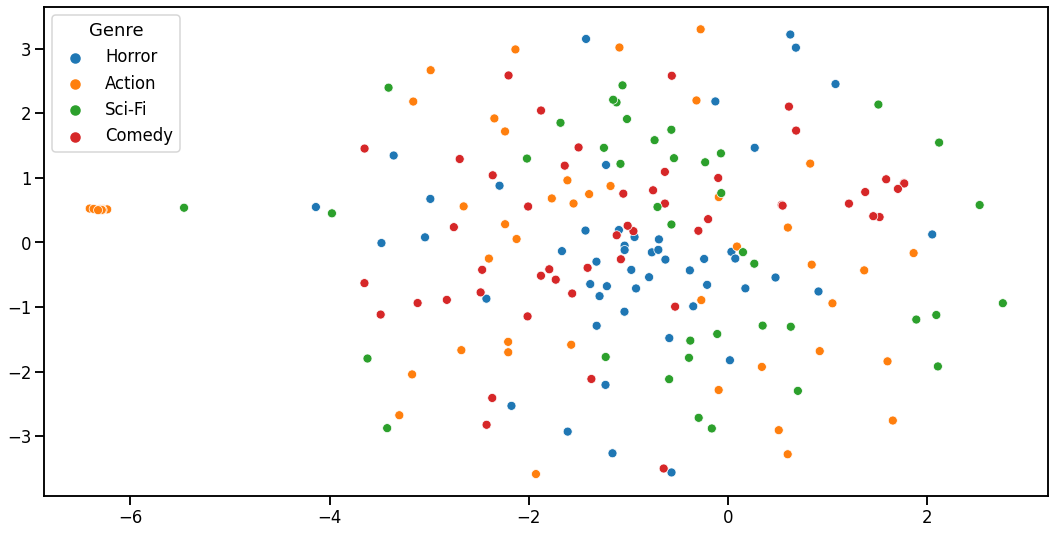

In [257]:
plt.figure(figsize=(18, 9))

sns.scatterplot(x=X, 
                y=Y, 
                hue=genres_corpus)

<AxesSubplot:>

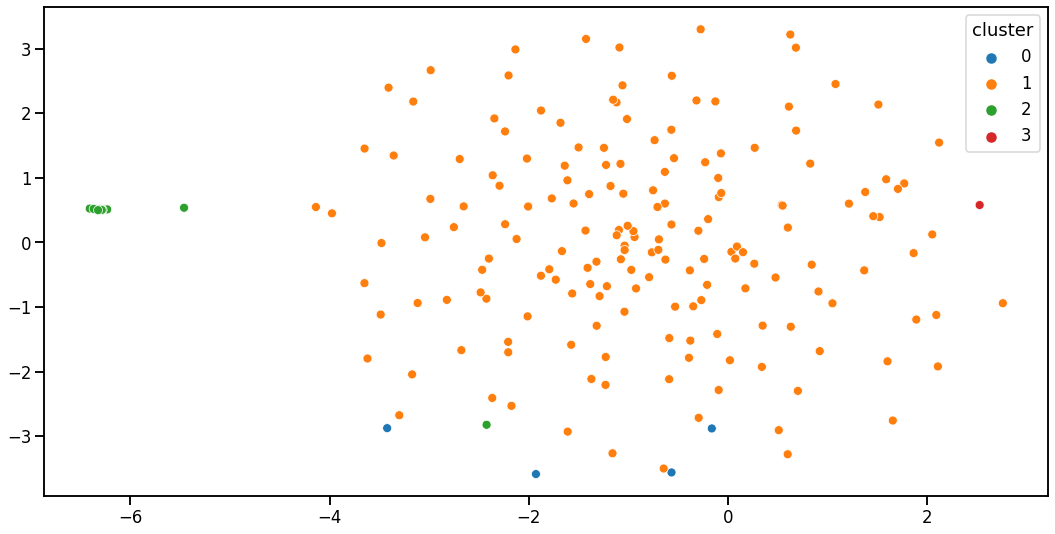

In [258]:
plt.figure(figsize=(18, 9))

labels_kmeans_str = pd.Series(labels_kmeans.astype(str), name='cluster')

sns.scatterplot(x=X, 
                y=Y, 
                hue=labels_kmeans_str,
                hue_order=['0', '1', '2', '3'])

In [259]:
np.unique(labels_kmeans_str, return_counts=True)

(array(['0', '1', '2', '3'], dtype=object), array([  4, 173,  12,   1]))